In [189]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import re
import csv

# Setup Parsing Functions

In [190]:
def simple_get(url):
    """
    Attempts to get the content at `url` by making an HTTP GET request.
    If the content-type of response is some kind of HTML/XML, return the
    text content, otherwise return None.
    """
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content
            else:
                print('error')
                return None

    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None

In [191]:
def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)

In [192]:
def get_data(url):
    raw_html = simple_get(url)

    soup = BeautifulSoup(raw_html, 'html.parser')
    url_parts = url.split("/")
    strain_id = url_parts[-2]+":"+url_parts[-1]
    name = ''
    try:
        name = " ".join(soup.title.getText().split(" ")[:-5])
    except:
        print('error in getting name')
  #  print(name)

    desc_text = ''
    try:
        desc = soup.find('div', class_='description')
        desc_text = desc.p.getText()
  #      print(desc.p.getText())
    except:
        print('',end='')

   # print()
   # print('GROW INFO:')

    grow_info_str = ''
    try:
        grow_info = soup.find_all('div', class_=['growInfoRow','growInfoRow desktopYield'])
        for grow in grow_info:
            val = grow.find(lambda tag: tag.name == 'div' and 
                                tag.get('class') and tag.get('class') == ['selected'] )
            label = grow.find(lambda tag: tag.name == 'div' and
                                tag.get('class') and tag.get('class') == ['strain__data'])
            label = label.text.strip()
            val = val.text.strip()

        #    print(label + ':' + val)
            grow_info_str += label + ':' + val + ','
      #  print()
    except:
        print('',end='')
                        

    effects = ''
    medical = ''
    negatives = ''

    try:
        categories = soup.find_all(lambda tag: tag.name == 'div' and
                                    tag.get('class') == ['m-histogram'])
        

        for cat in categories:
            category = cat['ng-show'].split('===')[1][1:-1]
          #  print(category)

            hists = cat.find_all(lambda tag: tag.name == 'div' and 
                                            tag.get('class') == ['m-histogram-item-wrapper'])
            for item in hists:
                label = item.find('div', class_='m-attr-label copy--sm').string
                val = item.find('div', class_='m-attr-bar')['style'].split(':')[1][:-1]
                val = round(float(val),2)
                if category == 'Effects':
                    effects += label + ':' + str(val) + ','
                elif category == 'Medical':
                    medical += label + ':' + str(val) + ','
                elif category == 'Negatives':
                    negatives += label + ':' + str(val) + ','
         #       print(label + ':sdf ' + str(val))
         #   print()

            
            
    except:
        print('',end='')

    all_flavors = 'Ammonia Apple Apricot Berry Blue Cheese Blueberry Butter Cheese Chemical Chestnut Citrus Coffee Diesel Earthy Flowery Grape Grapefruit Honey Lavender Lemon Lime Mango Menthol Mint Nutty Orange Peach Pear Pepper Pine Pineapple Plum Pungent Rose Sage Skunk Spicy/Herbal Strawberry Sweet Tar Tea Tobacco Tree Fruit Tropical Vanilla Violet Woody'
    
    flavor_str = ''
    try:
        flavors = soup.find_all(lambda tag: tag.name == 'li' and
                                    tag.get('class') and 
                                        tag.get('class')[0].find("grid-1-3 grid-xs-1-3 copy--centered colored-background") and
                                            tag.get('title') and tag.get('title').find(all_flavors))
      #  print('FLAVORS:')
        if flavors:
            for flavor in flavors:
            #    print(flavor['title'])
                flavor_str += flavor['title'] + ','
     #   print()
    except:
        print('',end='')
   # print('PARENTS:')

    parents_str = ''
    try:
        lineage = soup.find('div', class_='strain__lineage strain__dataTab')
        if lineage:
            parent = lineage.find_all(lambda tag: tag.name == 'a' and tag.get('href'))
            if parent:
                for p in parent:
                    par = p['href'].split('/')
                #    print('type: ' + par[len(par) - 2] + ' strain: ' + par[len(par) - 1])
                    parents_str += par[len(par) - 2] + ':' + par[len(par) - 1] + ','
    except:
        print('',end='')

    rate_str = ''
    try:
        rate = soup.find(lambda tag: tag.name == 'div' and 
                            tag.get('itemprop') and tag.get('itemprop') == 'aggregateRating')
        avg_rating = rate.find(lambda tag: tag.name == 'span' and tag.get('star-rating'))
        rate_str = avg_rating['star-rating']
    except:
        print('',end='')
    
    num_rate = ''
    try:
        num_ratings = rate.find(lambda tag: tag.name == 'span' and tag.get('itemprop') and
                            tag.get('itemprop') == 'reviewCount')
        num_rate = num_ratings.text
    except:
        print('',end='')
  #  print()

    
  #  if avg_rating and avg_rating['star-rating']:
    #    print(avg_rating['star-rating'])
   # if num_ratings and num_ratings.text:
     #   print(num_ratings.text)
    return {'strain_id':strain_id, 'url':url,'name':name,'desc':desc_text,
            'grow_info':grow_info_str,'effects':effects,'medical':medical,'negatives':negatives,
            'flavors':flavor_str,'parents':parents_str,'ratings':rate_str,'num_ratings':num_rate}


## Debug Parsing:

In [193]:
bad_name='sativa:island-maui-haze'
bad_name_parts = bad_name.split(':')
bad_url= 'https://www.leafly.com/%s/%s' % (bad_name_parts[0],bad_name_parts[1])
print(bad_url)
result = get_data(bad_url)
print(result)

https://www.leafly.com/sativa/island-maui-haze
{'strain_id': 'sativa:island-maui-haze', 'url': 'https://www.leafly.com/sativa/island-maui-haze', 'name': 'Island Maui Haze', 'desc': 'Island Maui Haze is a 75/25 sativa-dominant strain with effects that can creep up on you. These dense, forest green buds may not initially attract you based on its strong, ammonia smell; however, this crystal-covered strain is praised for its uplifting, energetic effects that can relieve pain and other symptoms without bringing you down into a lazy state.\xa0', 'grow_info': '', 'effects': 'Relaxed:100.0,Happy:97.62,Talkative:88.1,Euphoric:16.67,Tingly:9.52,', 'medical': 'Stress:100.0,Depression:90.91,Headaches:88.64,Pain:88.64,Inflammation:86.36,', 'negatives': 'Dry Mouth:100.0,Anxious:100.0,Paranoid:50.0,', 'flavors': 'Citrus,Mango,Tropical,', 'parents': '', 'ratings': '4.53333333333333', 'num_ratings': '15'}


# Extract & Parse URLs

In [194]:
# Extracting URLs from Leafly sitemap using BeautifulSoup to parse
soup = BeautifulSoup(open("./LeaflySitemap.xml", "r"), "lxml-xml")
urls  = [a.text for a in (urls.find("loc") for urls in soup.find_all("url")) if a]

# Extracting only strain URLs from the complete list
# Required URLs have format https://www.leafly.com/{sativa|indica|hybrid}/{strain_name}
regexExp = "https?:\/\/(www\.)?(leafly\.com)\/(hybrid|sativa|indica)\/+[^\/]+[-a-zA-Z0-9@:%._\+~#=]$"
regex = re.compile(regexExp)
strain_URLs = list(filter(regex.search, urls))

# Already run
# with open('strains.csv','w') as f:
#     fields = ['strain_id','url','name','desc','grow_info','effects','medical','negatives','flavors','parents','ratings','num_ratings']
#     csvwriter=csv.DictWriter(f, fieldnames=fields)
#     csvwriter.writeheader()

#     i = 0
#     siz = len(strain_URLs)
#     for url in strain_URLs:
#         result = get_data(url)
#         csvwriter.writerow(result)
#         # How far are we:
#         print('\r' + str(100 * i / siz),end='')
#         i+=1

# Data Cleaning
## TODO what do we need from this

In [195]:
import pandas as pd
import numpy as np

In [196]:
df = pd.read_csv('./strains.csv')

In [197]:
df['num_ratings'].fillna(value=0,inplace=True)
df['ratings'].fillna(value=0,inplace=True)

In [198]:
#new_df.to_csv('./strains_cleaned.csv',index=False)
df.to_csv('./strains_cleaned.csv',index=False)

# Filtering & Reformatting Data

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
plt.rcParams['figure.figsize'] = [12,12]

In [200]:
df = pd.read_csv('./strains_cleaned.csv')
df.head(20)

,strain_id,url,name,desc,grow_info,effects,medical,negatives,flavors,parents,ratings,num_ratings
0,hybrid:sweet-nina,https://www.leafly.com/hybrid/sweet-nina,Sweet Nina,Sweet Nina by Colorado Seed Inc. is a hybrid c...,NaN,"Happy:100.0,Relaxed:100.0,Euphoric:75.0,Uplift...","Stress:100.0,Inflammation:94.74,Nausea:94.74,P...","Dizzy:100.0,Paranoid:100.0,Anxious:100.0,Dry E...","Diesel,Skunk,Tobacco,","indica:hindu-kush,",3.857143,6.0
1,indica:hawaiian-purple-kush,https://www.leafly.com/indica/hawaiian-purple-...,Hawaiian Purple Kush,Hawaiian Purple Kush is an 80/20 indica-domina...,NaN,"Relaxed:100.0,Happy:94.95,Giggly:88.89,Creativ...","Stress:100.0,Insomnia:72.73,Depression:63.64,L...","Dry Mouth:100.0,Dry Eyes:97.62,Paranoid:92.86,...","Tropical,Earthy,Pungent,","sativa:hawaiian,indica:purple-kush,",4.486486,32.0
2,indica:lime-purple-mist,https://www.leafly.com/indica/lime-purple-mist,Lime Purple Mist,Lime Purple Mist is an indica-dominant strain ...,NaN,"Happy:100.0,Relaxed:100.0,Sleepy:66.67,Tingly:...","Cramps:100.0,Lack of Appetite:100.0,Pain:100.0...","Dry Mouth:100.0,","Berry,Lime,Spicy/Herbal,",NaN,4.333333,4.0
3,indica:fn-louzer,https://www.leafly.com/indica/fn-louzer,F'n louZER,F’n louZER is another potent genetic cross fro...,NaN,"Sleepy:100.0,Relaxed:100.0,Aroused:50.0,Tingly...","Lack of Appetite:100.0,Seizures:100.0,","Dizzy:100.0,Dry Eyes:100.0,Dry Mouth:100.0,Hea...","Diesel,Earthy,Pungent,","indica:bloos-kloos,indica:white-rhino,",0.000000,0.0
4,sativa:goldwing,https://www.leafly.com/sativa/goldwing,Goldwing,NaN,NaN,"Uplifted:100.0,Happy:100.0,Euphoric:60.0,Creat...","Stress:100.0,Depression:66.67,Nausea:66.67,Pai...","Dry Mouth:100.0,Dizzy:50.0,Dry Eyes:50.0,Heada...",NaN,NaN,4.666667,2.0
5,sativa:arabian-gold,https://www.leafly.com/sativa/arabian-gold,Arabian Gold,Arabian Gold is a heavy sativa strain of myste...,NaN,"Sleepy:100.0,Relaxed:98.04,Euphoric:8.82,Creat...","Stress:100.0,Insomnia:80.0,Pain:20.0,","Dry Mouth:100.0,Dry Eyes:62.5,Dizzy:25.0,Paran...",NaN,NaN,4.000000,11.0
6,indica:madagascar,https://www.leafly.com/indica/madagascar,Madagascar,"Madagascar is an indica with a clean, floral s...",NaN,"Sleepy:100.0,Happy:62.5,Euphoric:37.5,Relaxed:...","Insomnia:100.0,Stress:60.0,Pain:30.0,Headaches...","Dry Eyes:100.0,Dry Mouth:80.0,Dizzy:20.0,","Earthy,Sweet,Skunk,",NaN,4.100000,7.0
7,indica:murkle,https://www.leafly.com/indica/murkle,Murkle,Murkle by OBSoul is the accidental genetic pai...,NaN,"Sleepy:100.0,Talkative:100.0,Euphoric:100.0,Ha...","Depression:100.0,Inflammation:100.0,Insomnia:1...","Dry Mouth:100.0,Dizzy:80.0,Dry Eyes:80.0,Paran...","Sweet,Earthy,Pungent,","indica:m-39,indica:purple-urkle,",3.500000,2.0
8,sativa:berkeley,https://www.leafly.com/sativa/berkeley,Berkeley,Berkeley is rumored to be the super-potent bot...,NaN,"Energetic:100.0,Happy:100.0,Creative:95.83,Eup...","Stress:100.0,Depression:97.14,Nausea:8.57,Lack...","Anxious:100.0,Dry Eyes:83.33,Dry Mouth:66.67,P...","Citrus,Sweet,Pungent,",NaN,4.315789,21.0
9,hybrid:alf,https://www.leafly.com/hybrid/alf,Alf,The indica-dominant hybrid Alf was created by ...,"FLOWERING:10 - 12 wks,","Relaxed:100.0,Creative:50.0,Euphoric:50.0,Gigg...","Depression:100.0,Insomnia:100.0,Muscle Spasms:...","Dry Mouth:100.0,","Diesel,Tropical,Pungent,","hybrid:animal-cookies,hybrid:cherry-pie,hybrid...",5.000000,1.0


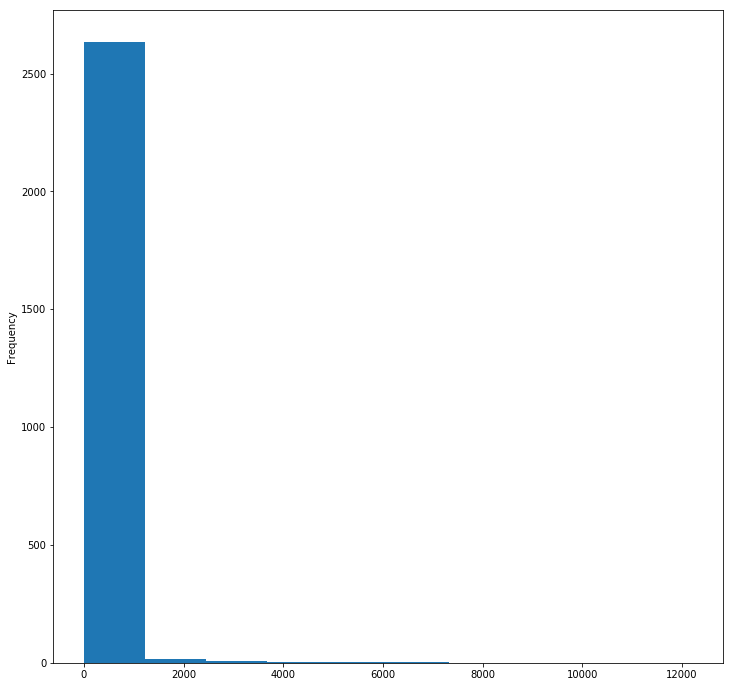

In [201]:
df['num_ratings'].plot.hist(bins=10)

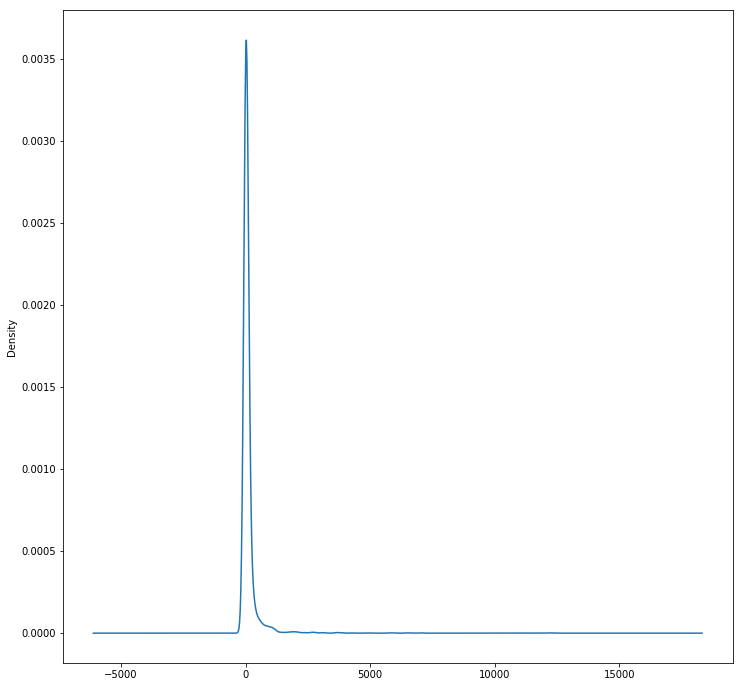

In [202]:
df['num_ratings'].plot.density()

In [203]:
df.shape

(2669, 12)

In [204]:
parents=df['parents'].str.split(',',expand=True).head()
parents

,0,1,2,3,4,5,6,7
0,indica:hindu-kush,,None,None,None,None,None,None
1,sativa:hawaiian,indica:purple-kush,,None,None,None,None,None
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,indica:bloos-kloos,indica:white-rhino,,None,None,None,None,None
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [205]:
parents[7].unique()

array([None, nan], dtype=object)

In [206]:
df0=df
df0.shape

(2669, 12)

In [207]:
import json
# Handle name changes that redirect but the backend was never updated
# Note that the second part of the name appears to be unique, but the first part is very important to classification
# The dictionary size could be reduced by adding fallback behaviour to try the other categories if missing
substituition_dict = {'hybrid:girl-scout-cookie':'hybrid:gsc',
                      'hybrid:platinum-girl-scout-cookies':'hybrid:platinum-gsc',
                      'hybrid:platinum-girl-scout-cookie':'hybrid:platinum-gsc',
                      'indica:ogre':'hybrid:ogre', 
                      'hybrid:skywalker-og':'hybrid:mazar-x-blueberry', 
                      'hybrid:hells-angel-og':'hybrid:hells-og',
                      'hybrid:gg-4':'hybrid:original-glue', 
                      'hybrid:gorilla-glue-4':'hybrid:original-glue', 
                      'sativa:north-american':'indica:north-american', 
                      'hybrid:nevilles-haze':'sativa:nevilles-haze', 
                      'sativa:jesus-og':'indica:jesus-og',
                      'hybrid:casey-jones':'sativa:casey-jones', 
                      'hybrid:trinity':'sativa:trinity', 
                      'hybrid:northern-lights--5':'indica:northern-lights--5', 
                      'hybrid:blue-mystic':'indica:blue-mystic', 
                      'indica:nepalese':'sativa:nepalese', 
                      'indica:blackberry':'hybrid:blackberry', 
                      'hybrid:querkle':'indica:querkle', 
                      'sativa:micky-kush':'sativa:mickey-kush', 
                      'indica:29aca226-23ba-4726-a4ab-f3bf68f2a3c4':'indica:dynamite', 
                      'hybrid:sweet-tooth':'indica:sweet-tooth', 
                      'hybrid:tangerine-sunrise':'sativa:tangerine-sunrise', 
                      'hybrid:rockstar-kush':'indica:rockstar-kush',
                      'sativa:rene':'hybrid:rene', 
                      'hybrid:hashplant-haze':'sativa:hashplant-haze', 
                      'hybrid:gorilla-glue-1':'hybrid:sister-glue', 
                      'hybrid:fruity-pebbles':'hybrid:fpog', 
                      'indica:skywalker':'hybrid:mazar-x-blueberry'}

def category(strain_id):
    categories = {"sativa":1,"hybrid":2,"indica":3}
    return categories[strain_id.split(':')[0]]

parent_ids=set() # All ids that show up in parents, thus we need them even if they don't have children
    
def precompute_ids(row):
        found_ids.add(row["strain_id"])
        if (row["parents"] and type(row["parents"])==str):
            for p in row["parents"].split(','):
                if not len(p):
                    continue
                elif p in substituition_dict:
                    parent_ids.add(substituition_dict[p])
                else:
                    parent_ids.add(p)


found_ids=set()
missing_ids=set()
nodes = []
links = []
info = {}
def calculate(row):
    strain_id = row["strain_id"]
    group = category(strain_id)
    parent_list = []
    if (row["parents"] and type(row["parents"]) == str):
        for p in row["parents"].split(','):
            if not len(p):
                continue
            elif p in substituition_dict:
                parent = substituition_dict[p]
            elif p not in found_ids:
                missing_ids.add(p)
                print("Strain %s is missing parent %s"%(strain_id,p))
                continue
            else:
                parent = p
            parent_list.append(parent) 
            # TODO what should the link value be? Do we even want one?
            links.append({ "source": parent, "target": strain_id})
        row["parents"] = parent_list
    if len(parent_list) or strain_id in parent_ids:
        nodes.append({"strain_id": strain_id, "name": row["name"], "group": group})
        # TODO completely redo info info[strain_id]=dict(row)
    else:
        print("Strain %s has no parents or children, discarding record" % strain_id,)
def reformat():
    df0.apply(precompute_ids,axis=1)        
    df0.apply(calculate,axis=1)
    if len(missing_ids):
        print("Warning, the following ids are missing and were ignored:")
        print(missing_ids)
    print("Total number of nodes output: %d" %len(nodes),) 

reformat()
df_nodes=pd.DataFrame(data=nodes).set_index('strain_id',verify_integrity=True)
df_edges=pd.DataFrame(data=links)


Strain indica:lime-purple-mist has no parents or children, discarding record
Strain sativa:goldwing has no parents or children, discarding record
Strain sativa:arabian-gold has no parents or children, discarding record
Strain indica:madagascar has no parents or children, discarding record
Strain sativa:berkeley has no parents or children, discarding record
Strain hybrid:rocky-mountain-high has no parents or children, discarding record
Strain hybrid:broke-diesel has no parents or children, discarding record
Strain hybrid:the-boss has no parents or children, discarding record
Strain hybrid:smelliot has no parents or children, discarding record
Strain hybrid:el-na has no parents or children, discarding record
Strain indica:og-eddy-lepp has no parents or children, discarding record
Strain hybrid:x-file has no parents or children, discarding record
Strain hybrid:little-devil has no parents or children, discarding record
Strain hybrid:redding-og has no parents or children, discarding record


In [208]:
df_edges.head()

,source,target
0,indica:hindu-kush,hybrid:sweet-nina
1,sativa:hawaiian,indica:hawaiian-purple-kush
2,indica:purple-kush,indica:hawaiian-purple-kush
3,indica:bloos-kloos,indica:fn-louzer
4,indica:white-rhino,indica:fn-louzer


In [209]:
# Remove cycles that are clearly mistakes so that it's a dag
df_edges.drop(df_edges[((df_edges['target']=='indica:purple-afghani') & (df_edges['source']=='indica:purple-kush'))].index,inplace=True)
df_edges.drop(df_edges[((df_edges['target']=='sativa:timewreck') & (df_edges['source']=='sativa:timewreck'))].index,inplace=True)

In [210]:
df_edges[df_edges.target.isin(df_nodes.index)].head()

,source,target
0,indica:hindu-kush,hybrid:sweet-nina
1,sativa:hawaiian,indica:hawaiian-purple-kush
2,indica:purple-kush,indica:hawaiian-purple-kush
3,indica:bloos-kloos,indica:fn-louzer
4,indica:white-rhino,indica:fn-louzer


In [211]:
# Remove edges involving non-existant nodes so that networkx doesn't freak out
df_edges2=df_edges[df_edges.target.isin(df_nodes.index)]
df_edges2=df_edges2[df_edges2.source.isin(df_nodes.index)]
df_edges2.head()

,source,target
0,indica:hindu-kush,hybrid:sweet-nina
1,sativa:hawaiian,indica:hawaiian-purple-kush
2,indica:purple-kush,indica:hawaiian-purple-kush
3,indica:bloos-kloos,indica:fn-louzer
4,indica:white-rhino,indica:fn-louzer


In [234]:
G=nx.DiGraph(df_edges2,edge_attr=True)
G

In [235]:
are_good=nx.is_directed_acyclic_graph(G)
if not are_good:
    print(nx.find_cycle(G))
assert are_good, "Graph must be a directed acyclic graph"


In [236]:
source_nodes=[]
for (strain_id,value) in G.in_degree():
    if value == 0:
        source_nodes.append(strain_id)
print(len(source_nodes))
print(source_nodes)

102
['indica:hindu-kush', 'sativa:hawaiian', 'indica:frankenstein', 'hybrid:the-white', 'indica:pre-98-bubba-kush', 'indica:double-purple-doja', 'indica:silverback-gorilla', 'sativa:south-indian', 'hybrid:nebula', 'sativa:charlottes-web', 'indica:afghani', 'indica:sensi-star', 'indica:g-13', 'hybrid:bubble-gum', 'sativa:thai', 'sativa:central-american', 'hybrid:burmese-kush', 'hybrid:ocas-cloud-9', 'indica:triangle-kush', 'sativa:strawberry-cough', 'indica:north-indian', 'sativa:mexican', 'indica:eastern-european', 'hybrid:silver-surfer', 'hybrid:dutch-treat', 'sativa:matanuska-thunder-fuck', 'sativa:african', 'hybrid:the-one', 'sativa:lemon-thai', 'sativa:nepalese', 'hybrid:ginger-ale', 'sativa:jamaican', 'hybrid:california-orange', 'hybrid:saturn-og', 'indica:kosher-kush', 'indica:purple-elephant', 'hybrid:pink-panther', 'sativa:south-american', 'indica:south-asian', 'sativa:tangerine-sunrise', 'hybrid:spirit-of-76', 'indica:caramella', 'sativa:early-pearl', 'indica:pakistani-chitral

In [237]:
leaf_nodes=[]
for (strain_id,value) in G.out_degree():
    if value == 0:
        leaf_nodes.append(strain_id)
print(len(leaf_nodes))
print(leaf_nodes)

1582
['hybrid:sweet-nina', 'indica:fn-louzer', 'indica:murkle', 'hybrid:alf', 'hybrid:northern-cross', 'hybrid:damnesia', 'hybrid:sunlight-skunk', 'hybrid:white-ryder', 'hybrid:loyality', 'indica:sweet-lafayette', 'sativa:alpha-cow', 'hybrid:armagnac', 'indica:bubba-doja', 'hybrid:peyton-manning', 'hybrid:diamond-socks', 'hybrid:bootlegger', 'sativa:doox', 'indica:kelly-hill-gold', 'indica:pestilence', 'indica:ifc-og', 'sativa:haze-mist', 'indica:space-monster', 'hybrid:spyder-mon', 'hybrid:sorcerers-apprentice', 'hybrid:white-walrus', 'hybrid:brain-candy', 'hybrid:goat', 'hybrid:chairman-chem-sou', 'hybrid:cello-sweet-og', 'sativa:kaboom', 'indica:tonics-web', 'hybrid:batgirl', 'hybrid:prismatic-jack', 'hybrid:cheesewreck', 'hybrid:lazy-train', 'hybrid:afghanica', 'hybrid:boggle-gum', 'indica:afghanimal', 'hybrid:the-big-dirty', 'hybrid:gupta-haze', 'hybrid:pan-jam', 'indica:sumo-og-kush', 'indica:berry-noir', 'hybrid:flowers-for-algernon', 'indica:la-ultra', 'indica:denver-maple', 'i

In [238]:
# We already filtered out unconnected strains, so we shouldn't have any here
for (strain_id, value) in G.degree():
    assert value != 0, "No vertices should be unconnected"

In [239]:
df_nodes.insert(2,'depth',-1)


ValueError: cannot insert depth, already exists

In [240]:
for src in source_nodes:
    df_nodes.loc[src,'depth']=0
df_nodes.sort_values('depth').head(10)

,group,name,depth
strain_id,,,
hybrid:black-cherry-soda,2,Black Cherry Soda,0
indica:sensi-star,3,Sensi Star,0
indica:starbud,3,StarBud,0
hybrid:sharks-breath,2,Sharksbreath,0
sativa:frostbite,1,Frostbite,0
hybrid:ocas-cloud-9,2,OCA’s Cloud 9,0
hybrid:98-white-widow,2,'98 Aloha White Widow,0
indica:chemo,3,Chemo,0
hybrid:silver-surfer,2,Silver Surfer,0


In [241]:
while not nx.is_empty(G):
    longest_path=nx.dag_longest_path(G)
    deepest_node=longest_path[-1]
    df_nodes.loc[deepest_node,'depth']=len(longest_path)-1
    G.remove_node(deepest_node)

In [220]:
df_nodes.loc[:,'depth'].value_counts()

5     392
4     390
3     343
2     286
6     215
1     176
7     162
0     102
8      96
9      48
10      4
Name: depth, dtype: int64

In [221]:
df_nodes.loc[:,'depth'].head()

strain_id
hybrid:sweet-nina              1
indica:hawaiian-purple-kush    3
indica:fn-louzer               5
indica:murkle                  4
hybrid:alf                     7
Name: depth, dtype: int64

In [222]:
invalid_depths = df_nodes['depth'].value_counts().index.contains(-1)
assert (not invalid_depths), "All nodes must be given a positive depth value"

In [223]:
def calculate_dist(d):
    parent_depth= df_nodes.loc[d['source'],'depth']
    child_depth=df_nodes.loc[d['target'],'depth']
    return child_depth-parent_depth
df_edges2['distance'] = df_edges2.apply(calculate_dist,axis=1)
df_edges2.head()

,source,target,distance
0,indica:hindu-kush,hybrid:sweet-nina,1
1,sativa:hawaiian,indica:hawaiian-purple-kush,3
2,indica:purple-kush,indica:hawaiian-purple-kush,1
3,indica:bloos-kloos,indica:fn-louzer,1
4,indica:white-rhino,indica:fn-louzer,3


In [224]:
# This should be empty:
empty = len(df_edges2[df_edges2['distance']<=0])==0
assert empty, "Edges must have positive distances"

## Reduce data for purposes of visualization

In [243]:
df1 = df0.set_index('strain_id')

In [310]:
# Remove sources with few children
# Start by reseting graph
G=nx.DiGraph(df_edges2,edge_attr=True)
print(df_nodes.shape)
df_nodes_out=df_nodes.copy()
for strain_id in source_nodes:
    degree = G.degree(strain_id)
    if degree and degree < 5:
        df_nodes_out.drop(index=strain_id,axis=0,inplace=True)
for (strain_id,degree) in G.degree:
    if not degree:
        df_nodes_out.drop(index=strain_id,axis=0,inplace=True)

# df_src=df1.loc[source_nodes]
# prune_roots=df_src.loc[df_src['num_ratings']<20].index

# 
# df_nodes_out=df_nodes.drop(prune_roots,axis=0)
print(df_nodes_out.shape)
df_nodes_out.head()

(2214, 3)
(2140, 3)


,group,name,depth
strain_id,,,
hybrid:sweet-nina,2,Sweet Nina,1
indica:hawaiian-purple-kush,3,Hawaiian Purple Kush,3
indica:fn-louzer,3,F'n louZER,5
indica:murkle,3,Murkle,4
hybrid:alf,2,Alf,7


In [311]:
df_leaf=df1.loc[leaf_nodes]
cutoff=150
prune_leaves=df_leaf.loc[df_leaf['num_ratings']<cutoff].index
print(len(prune_leaves))
prune_leaves

1505


Index(['hybrid:sweet-nina', 'indica:fn-louzer', 'indica:murkle', 'hybrid:alf',
       'hybrid:northern-cross', 'hybrid:damnesia', 'hybrid:sunlight-skunk',
       'hybrid:white-ryder', 'hybrid:loyality', 'indica:sweet-lafayette',
       ...
       'sativa:kerosene', 'indica:papas-og', 'sativa:green-goblin',
       'hybrid:ice-wreck', 'hybrid:jenny-kush', 'sativa:sun-ra',
       'indica:guard-dawg', 'hybrid:honey-bananas', 'sativa:white-buffalo',
       'hybrid:boss-og'],
      dtype='object', name='strain_id', length=1505)

In [312]:
print(df_nodes.shape)
df_nodes_out.drop(prune_leaves,axis=0,inplace=True)
print(df_nodes_out.shape)
df_nodes_out.head()

(2214, 3)
(635, 3)


,group,name,depth
strain_id,,,
indica:hawaiian-purple-kush,3,Hawaiian Purple Kush,3
hybrid:big-skunk-korean,2,Big Skunk Korean,4
indica:mad-scientist,3,Mad Scientist,3
indica:colorado-bubba,3,Colorado Bubba,2
indica:motavation,3,Motavation,4


In [313]:
# Truncate the tree a bit too to reduce clutter
print(df_nodes_out.shape)
df_nodes_out.drop(df_nodes_out.loc[df_nodes_out['depth']>6].index,inplace=True)
for (strain_id,degree) in G.degree:
    if not degree and strain_id in df_nodes_out.index:
        df_nodes_out.drop(index=strain_id,axis=0,inplace=True)

(635, 3)


In [314]:
print(df_edges2.shape)
df_edges_out=df_edges2[df_edges2.target.isin(df_nodes_out.index)]
df_edges_out=df_edges_out[df_edges_out.source.isin(df_nodes_out.index)]
print(df_edges_out.shape)
df_edges_out.head()

(3914, 3)
(1003, 3)


,source,target,distance
1,sativa:hawaiian,indica:hawaiian-purple-kush,3
2,indica:purple-kush,indica:hawaiian-purple-kush,1
14,indica:big-bud,hybrid:big-skunk-korean,1
15,hybrid:skunk-1,hybrid:big-skunk-korean,2
39,indica:herojuana,indica:mad-scientist,1


In [319]:
# Remove any still-dangling vertices
G=nx.DiGraph(df_edges_out,edge_attr=True)
print(df_nodes_out.shape)
for strain_id in df_nodes_out.index:
    degree = G.degree(strain_id)
    if strain_id in df_nodes_out.index and ((type(degree) != int) or (degree == 0)) :
        df_nodes_out.drop(index=strain_id,axis=0,inplace=True)
print(df_nodes_out.shape)
df_nodes_out.sort_values(by='depth').head()

(576, 3)
(570, 3)


,group,name,depth
strain_id,,,
indica:hindu-kush,3,Hindu Kush,0
indica:triangle-kush,3,Triangle Kush,0
indica:kosher-kush,3,Kosher Kush,0
sativa:jamaican,1,Jamaican,0
hybrid:dutch-treat,2,Dutch Treat,0


In [320]:
# One last cleanup
print(df_edges_out.shape)
df_edges_out=df_edges_out[df_edges_out.target.isin(df_nodes_out.index)]
df_edges_out=df_edges_out[df_edges_out.source.isin(df_nodes_out.index)]
print(df_edges_out.shape)
df_edges_out.head()

(1003, 3)
(1003, 3)


,source,target,distance
1,sativa:hawaiian,indica:hawaiian-purple-kush,3
2,indica:purple-kush,indica:hawaiian-purple-kush,1
14,indica:big-bud,hybrid:big-skunk-korean,1
15,hybrid:skunk-1,hybrid:big-skunk-korean,2
39,indica:herojuana,indica:mad-scientist,1


In [321]:
with open('strains_formatted.json','w') as outfile:
         json.dump({"nodes":df_nodes_out.reset_index().to_dict(orient='records'), "links":df_edges_out.to_dict(orient='records'),"info":info},outfile)